In [3]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rcParams
import pandas as pd
import math
import numpy as np

from pathlib import Path


import seaborn as sns
sns.set_theme()

import warnings
def relplot(*args, **kwargs):
        
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        return sns.relplot(*args, **kwargs)


results_path = Path('/home/selker/eop/eop/run_simulations/results')
figs_path = Path('/home/selker/eop/eop/run_simulations/figs')
figs_path.mkdir(exist_ok=True)

malawi = pd.read_parquet('/home/selker/eop/data/malawi/malawi_cleaned_2019.parquet')

## Comparing gap and rate targeting

In [13]:
gap_targeting_results = pd.read_csv(results_path / 'gap' / 'malawi.csv')

gap_targeting_results.loc[gap_targeting_results.features == 'selected_durable', 'method'] = (
    'gap (30 covariates)'
)
gap_targeting_results.loc[gap_targeting_results.features == 'all_durable', 'method'] = (
    'gap (147 covariates)'
)
gap_targeting_results.loc[gap_targeting_results.features == '4_selected_durable', 'method'] = (
    'gap (4 covariates)'
)
gap_targeting_results.loc[gap_targeting_results.features == 'EA', 'method'] = (
    'gap (EA fixed effects)'
)
gap_targeting_results.loc[gap_targeting_results.features == 'district', 'method'] = (
    'gap (district fixed effects)'
)
gap_targeting_results.loc[gap_targeting_results.features == 'mosaiks', 'method'] = (
    'gap (mosaiks features)'
)

gap_targeting_results = gap_targeting_results[gap_targeting_results.features != '3_selected_durable']

rate_targeting_results = pd.read_csv(results_path / 'rate_for_gap_comparison' / 'malawi.csv')
rate_targeting_results.method = 'rate (30 covariates)'

In [14]:
gap_targeting_results.method.value_counts()

method
gap (30 covariates)             20
gap (4 covariates)              20
gap (mosaiks features)          20
gap (EA fixed effects)          20
gap (district fixed effects)    20
Name: count, dtype: int64

In [15]:
both = pd.concat((gap_targeting_results, rate_targeting_results))

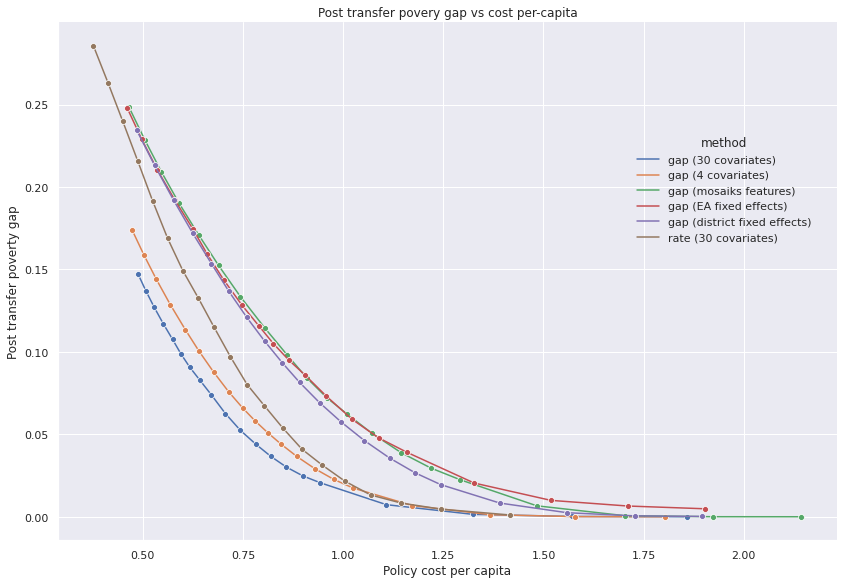

In [16]:
fg = relplot(
    data=both, kind='line',
    x="policy_cost_per_capita", y="post_transfer_poverty_gap", hue="method",
    marker='o', height=8, aspect=12/8
)
fg.set(
    xlabel='Policy cost per capita', ylabel='Post transfer poverty gap', 
    title='Post transfer povery gap vs cost per-capita'
)
sns.move_legend(fg, "upper right",bbox_to_anchor=(.8,.8))

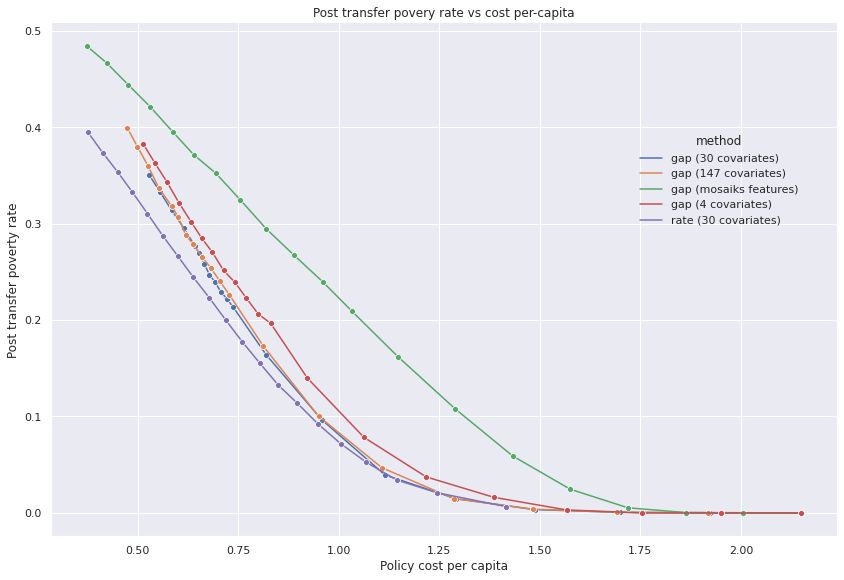

In [61]:
fg = relplot(
    data=both, kind='line',
    x="policy_cost_per_capita", y="post_transfer_poverty_rate", hue="method",
    marker='o', height=8, aspect=12/8
)
fg.set(
    xlabel='Policy cost per capita', ylabel='Post transfer poverty rate', 
    title='Post transfer povery rate vs cost per-capita'
)
sns.move_legend(fg, "upper right",bbox_to_anchor=(.8,.8))

## Gap targeting parameter search

In [4]:
gap_targeting_parameter_search_results = pd.read_csv(results_path / 'gap_parameter_search' / 'malawi.csv')

gap_targeting_parameter_search_results.drop_duplicates(
    subset=[
        'method', 'unconditional_tolerance', 'conditional_tolerance', 'd', 'nclass', 
        'features', 'lambda', 'n_quantiles', 'hidden_layer_size'
    ],
    keep='last', inplace=True
)

gap_targeting_parameter_search_results.rename(
    columns={
        'n_quantiles': 'Number of quantiles fit',
        'hidden_layer_size': 'Neurons in hidden layer',
    }, 
    inplace=True
)

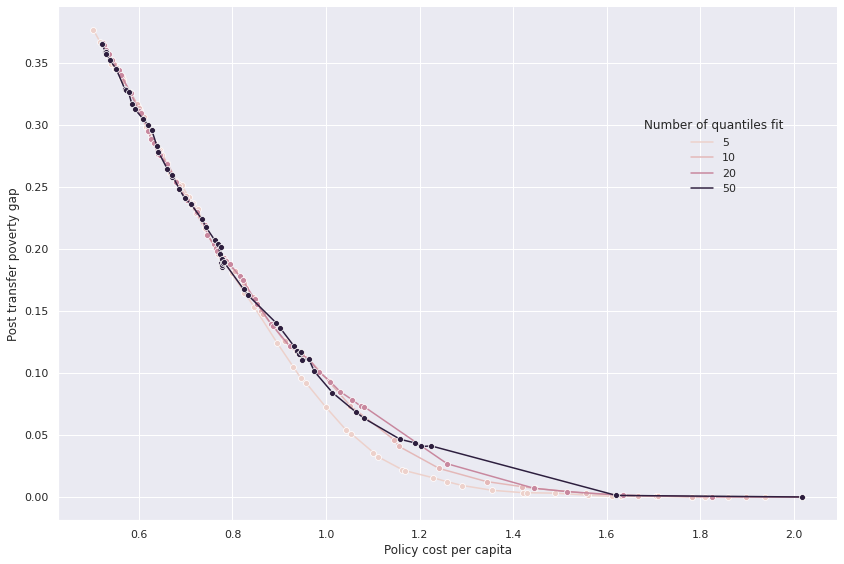

In [62]:
to_plot=gap_targeting_parameter_search_results[
    (gap_targeting_parameter_search_results['Neurons in hidden layer'] == 64)
    & (gap_targeting_parameter_search_results['features'] == 'all_durable')
]
fg = relplot(
    data=to_plot, kind='line',
    x="policy_cost_per_capita", y="post_transfer_poverty_rate", hue="Number of quantiles fit",
    marker='o', height=8, aspect=12/8
)
fg.set(xlabel='Policy cost per capita', ylabel='Post transfer poverty gap')
sns.move_legend(fg, "upper right",bbox_to_anchor=(.8,.8))

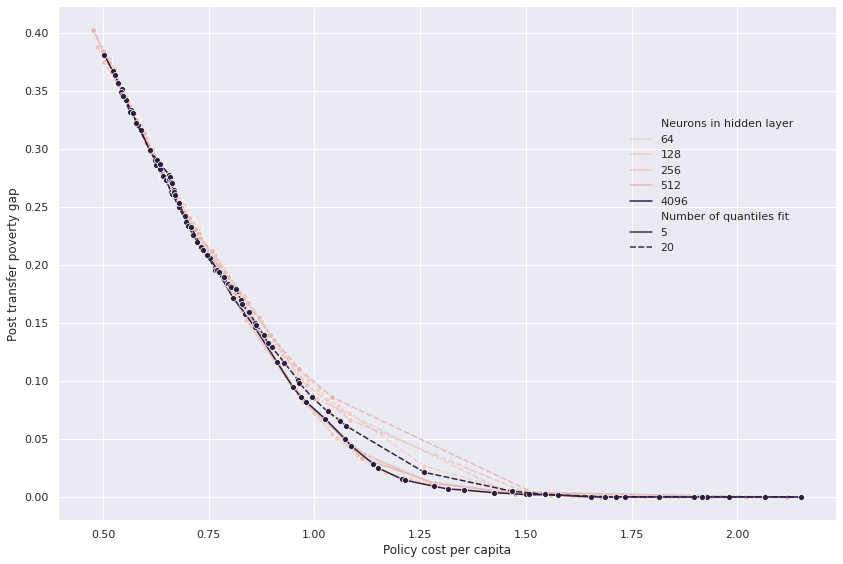

In [63]:
to_plot=gap_targeting_parameter_search_results[
    (gap_targeting_parameter_search_results['Number of quantiles fit'].isin([5,20]))
    & (gap_targeting_parameter_search_results['features'] == 'all_durable')

]
fg = relplot(
    data=to_plot, kind='line',
    x="policy_cost_per_capita", y="post_transfer_poverty_rate", hue="Neurons in hidden layer",
    style='Number of quantiles fit',
    marker='o', height=8, aspect=12/8
)
fg.set(xlabel='Policy cost per capita', ylabel='Post transfer poverty gap')
sns.move_legend(fg, "upper right",bbox_to_anchor=(.8,.8))

In [ ]:
to_plot=gap_targeting_parameter_search_results[
    (gap_targeting_parameter_search_results['features'] == 'mosaiks')
    & (gap_targeting_parameter_search_results['Neurons in hidden layer'] != 5000)
    #& (gap_targeting_parameter_search_results['Number of quantiles fit'] == 20)

]
fg = relplot(
    data=to_plot, kind='line',
    x="policy_cost_per_capita", y="post_transfer_poverty_rate", hue="Neurons in hidden layer",
    style='Number of quantiles fit',
    marker='o', height=8, aspect=12/8
)
fg.set(xlabel='Policy cost per capita', ylabel='Post transfer poverty gap')
sns.move_legend(fg, "upper right",bbox_to_anchor=(.8,.8))

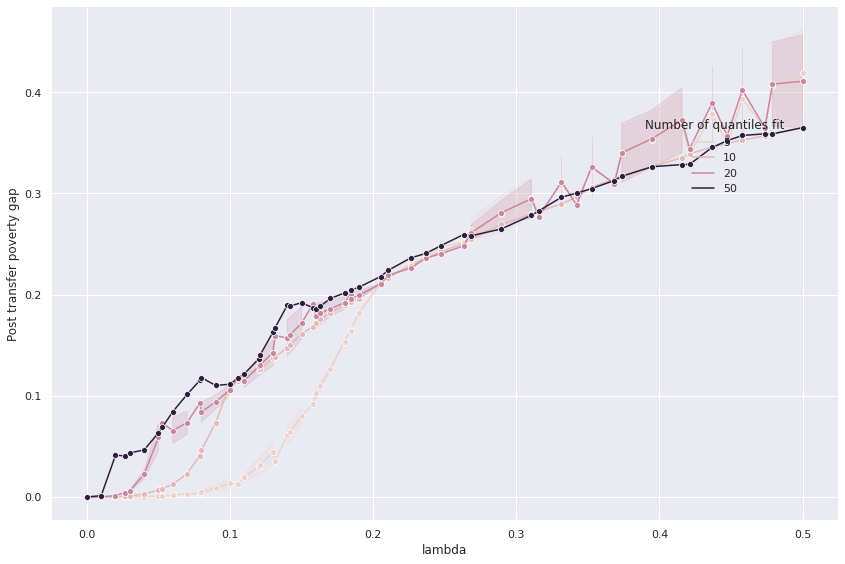

In [65]:
to_plot=gap_targeting_parameter_search_results[
    gap_targeting_parameter_search_results['Neurons in hidden layer'] == 64
]
fg = relplot(
    data=to_plot, kind='line',
    x="lambda", y="post_transfer_poverty_rate", hue="Number of quantiles fit",
    marker='o', height=8, aspect=12/8
)
fg.set(ylabel='Post transfer poverty gap')
sns.move_legend(fg, "upper right",bbox_to_anchor=(.8,.8))

## Subnational analysis

In [7]:
def plot_with_faceting(df, x_column, y_column, x_label, y_label, line_grouping_column, faceting_column, country):

    facet_groups = df.groupby(faceting_column)

    fig, axs = plt.subplots(2, math.ceil(len(facet_groups)/2), figsize=(12, 8), sharey=True) 
    for i, (facet_label, group) in enumerate(facet_groups):
        # Determine subplot index
        row = i // 2
        col = i % 2
        ax = axs[row, col]

        # Iterate over groups
        for group_label, group in group.groupby(line_grouping_column):
            # Plot y_column against x_column
            ax.plot(group[x_column], group[y_column], label=group_label, marker="o")

        if 'tolerance' in x_column and y_column == "post_transfer_poverty_rate":
            ax.plot(group[x_column], group[x_column], label="y=x", linestyle="dashed", color="black")

        # Add labels and title to each subplot
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(f'{faceting_column} = {facet_label}')
        legend = ax.legend()
        legend.set_title(line_grouping_column)

        # Add grid
        ax.grid(True)

    # Adjust layout and display plot
    plt.suptitle("{}: {} vs. {}".format(country, y_label, x_label))
    plt.tight_layout()
    plt.savefig(figs_path / "{}_{}_{}.pdf".format(country.lower(), x_column, y_column))
    plt.show()


def plot_without_faceting(
    df, x_column, y_column, x_label, y_label, line_grouping_column, country
):

    fig, ax = plt.subplots(1,1, figsize=(12, 8)) 

    # Iterate over groups
    for group_label, group in df.groupby(line_grouping_column):
        # Plot y_column against x_column
        ax.plot(group[x_column], group[y_column], label=group_label, marker="o")

    if 'tolerance' in x_column and y_column == "post_transfer_poverty_rate":
        ax.plot(group[x_column], group[x_column], label="y=x", linestyle="dashed", color="black")

    # Add labels and title to each subplot
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    legend = ax.legend()
    legend.set_title(line_grouping_column)


    # Add grid
    ax.grid(True)

    # Adjust layout and display plot
    plt.suptitle("{}: {} vs. {}".format(country, y_label, x_label))
    
    plt.tight_layout()
    plt.savefig(figs_path / "{}_{}_{}.pdf".format(country.lower(), x_column, y_column))
    plt.show()

def scatter_plots(
    df, x_column, y_columns, x_label, y_labels, row_for_line, subplots_with_line, country, bars_below_column=None,
    bars_below_label=None
):

    num_rows = math.ceil(len(y_columns)/2)
    num_cols = 2


    if bars_below_column:
        gs = gridspec.GridSpec(3 * num_rows, 2, height_ratios=num_rows * [2, 1, 1], hspace=0.0) 
        fig = plt.figure(figsize=(8*num_cols ,6*num_rows))

    else:
        gs = gridspec.GridSpec(num_rows, 2, height_ratios=num_rows * [1]) 
        fig = plt.figure(figsize=(8*num_cols , 8*num_rows))

    if not subplots_with_line:
        subplots_with_line = []

    for i, (y_column, y_label) in enumerate(zip(y_columns, y_labels)):

        col = i % 2

        # Determine subplot index
        if bars_below_column:
            row = (i // 2) * 3
            ax_bars = fig.add_subplot(gs[row+1, col] )
            ax_main = fig.add_subplot(gs[row, col], sharex=ax_bars)

        else:
            row = i // 2
            ax_main = fig.add_subplot(gs[row, col])

        ax_with_x_axis = ax_bars if bars_below_column else ax_main
        ax_with_x_axis.tick_params(axis='x', labelrotation=90) 

        sorted = df.sort_values(y_column)

        ax_main.scatter(
            sorted[x_column], sorted[y_column], color='k'
        )
        ax_main.set_ylabel(y_label)

        if bars_below_column:
            ax_bars.bar(sorted[x_column], sorted[bars_below_column])
            ax_bars.set_ylabel(bars_below_label if bars_below_label else bars_below_column)
            plt.setp(ax_main.get_xticklabels(), visible=False)

        # Add labels and title to each subplot
        if x_label:
            ax_with_x_axis.set_xlabel(x_label)

        if i in subplots_with_line:
            ax_main.axhline(y=row_for_line[y_column].values, label=row_for_line[x_column], color='b')
            ax_main.text(
                22, row_for_line[y_column].values + 0.02, 'Entire Country', color='b', verticalalignment='bottom'
            )

    fig.tight_layout()
    # fig.subplots_adjust(hspace=0.0)
    fig.savefig(figs_path / "{}_{}_{}.pdf".format(country.lower(), x_column, y_column))

In [ ]:
df = pd.read_csv(results_path /'results_for_subnational_analysis' / 'malawi.csv')

df['total_cost'] = df['policy_cost_per_capita'] * df['weight_adjusted_population']
df['initial_poverty_count'] = df['initial_poverty_rate'] * df['weight_adjusted_population']
df['post_transfer_poverty_count'] = df['post_transfer_poverty_rate'] * df['weight_adjusted_population']
df['initial_total_poverty_gap'] = df['initial_poverty_gap'] * df['weight_adjusted_population']
df['post_transfer_total_poverty_gap'] = df['post_transfer_poverty_gap'] * df['weight_adjusted_population']

df['poverty_count_reduction'] = (df.initial_poverty_count- df.post_transfer_poverty_count)
df['total_poverty_gap_reduction'] = (df.initial_total_poverty_gap - df.post_transfer_total_poverty_gap)

df['cost_per_poverty_count_reduction'] = df['total_cost'] / df.poverty_count_reduction
df['cost_per_total_poverty_gap_reduction'] = df['total_cost'] / df.total_poverty_gap_reduction

df['poverty_rate_reduction'] = (df.initial_poverty_rate- df.post_transfer_poverty_rate)
df['poverty_gap_reduction'] = (df.initial_poverty_gap - df.post_transfer_poverty_gap)

full_country = df[df.features == 'full_country']
df = df[df.features != 'full_country']

In [65]:
gs = gridspec.GridSpec(2, 2,  height_ratios= [2, 1]) 

In [69]:
gs[0]

GridSpec(2, 2, height_ratios=[2, 1])[0:1, 0:1]

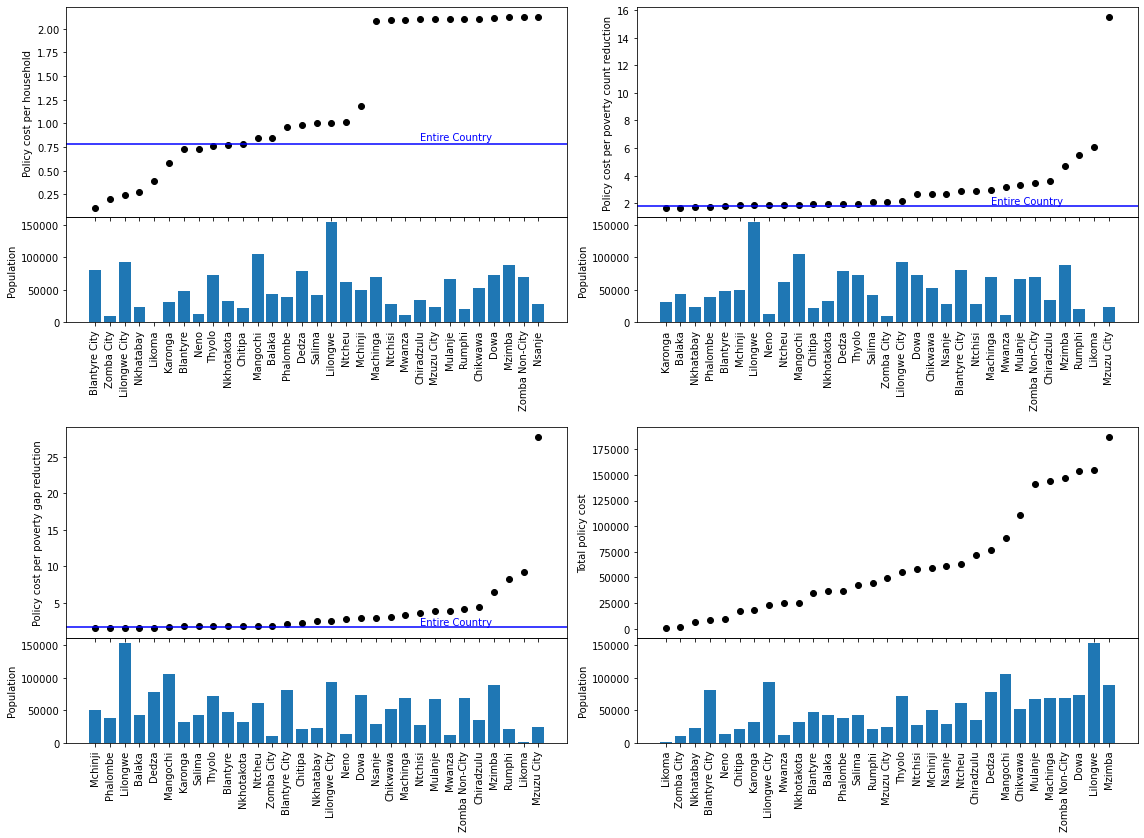

In [139]:
scatter_plots(
    df[
        (df['unconditional_tolerance'] == 0.2)
    ],
    x_column='features',
    y_columns = [
        'policy_cost_per_capita', 'cost_per_poverty_count_reduction', 'cost_per_total_poverty_gap_reduction', 'total_cost'
    ],
    x_label=None,
    y_labels = ['Policy cost per household', 'Policy cost per poverty count reduction', 'Policy cost per poverty gap reduction', 'Total policy cost'],
    country='Malawi',
    row_for_line=full_country,
    subplots_with_line=[0,1,2],
    bars_below_column='weight_adjusted_population',
    bars_below_label='Population'
)

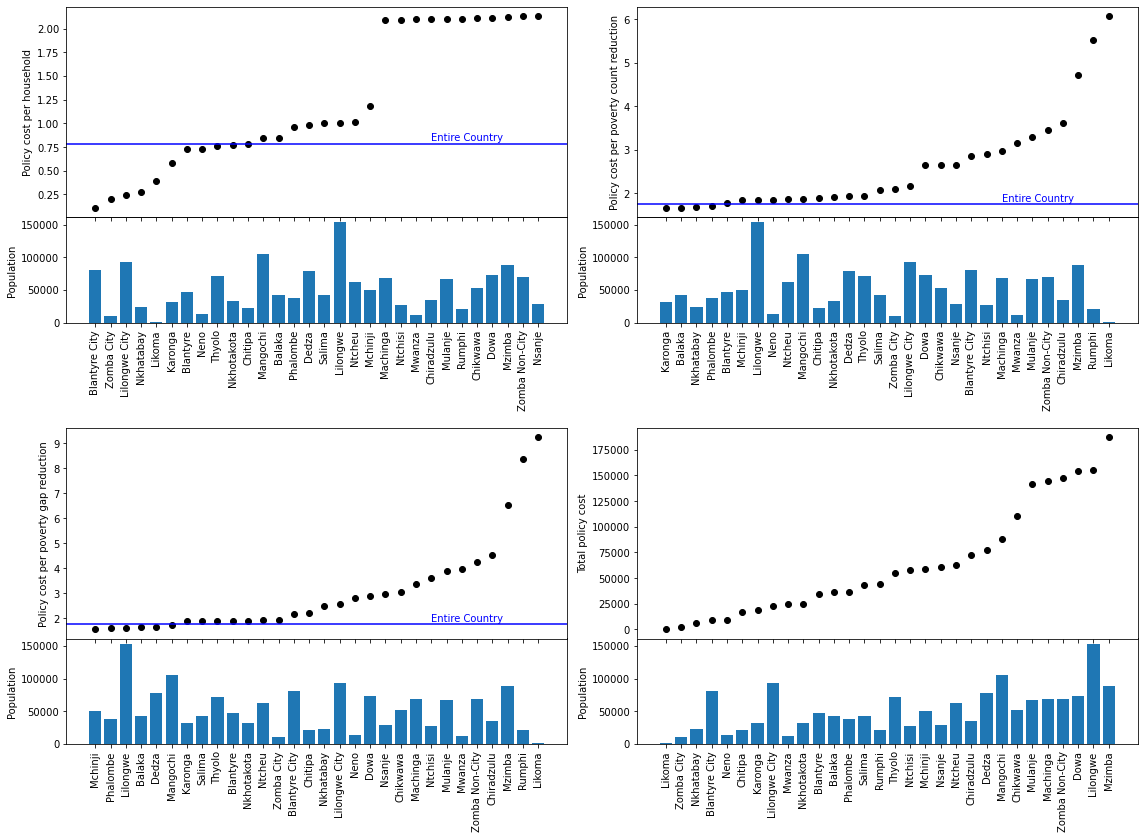

In [142]:
scatter_plots(
    df[
        (df['unconditional_tolerance'] == 0.2)
        & (df['features'] != 'Mzuzu City')
    ],
    x_column='features',
    y_columns = [
        'policy_cost_per_capita', 'cost_per_poverty_count_reduction', 'cost_per_total_poverty_gap_reduction', 'total_cost'
    ],
    x_label=None, 
    y_labels = ['Policy cost per household', 'Policy cost per poverty count reduction', 'Policy cost per poverty gap reduction', 'Total policy cost'],
    country='Malawi',
    row_for_line=full_country,
    subplots_with_line=[0,1,2],
    bars_below_column='weight_adjusted_population',
    bars_below_label='Population'
)

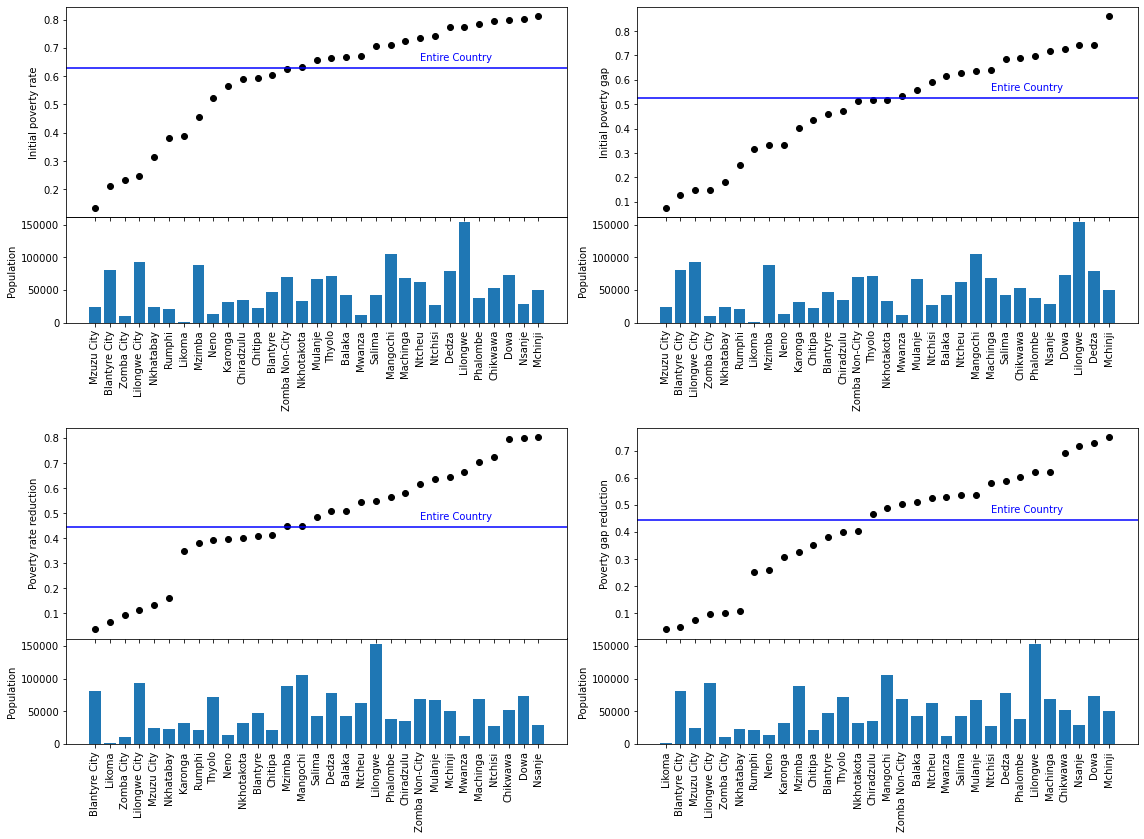

In [143]:
scatter_plots(
    df[
        (df['unconditional_tolerance'] == 0.2)
    ],
    x_column='features',
    y_columns = [
        'initial_poverty_rate', 'initial_poverty_gap', 'poverty_rate_reduction', 'poverty_gap_reduction'
    ],
    x_label=None, 
    y_labels = ['Initial poverty rate', 'Initial poverty gap', 'Poverty rate reduction', 'Poverty gap reduction'],
    country='Malawi',
    row_for_line=full_country,
    subplots_with_line=[0,1,2, 3],
    bars_below_column='weight_adjusted_population',
    bars_below_label='Population'
)